<a href="https://colab.research.google.com/github/Minh-Nguyen-2k7/BCI-Unity/blob/main/EEG_ver1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 **BCI Motor Imagery: Real-Time Unity Control** (Ver. 1)

### **Developer:** Ngoc Quang Minh Nguyen

### **System Specs:** 64-Channel EEG | Sampling Rate: **160Hz**

### **Objective:** Classify Mu **(8-12 Hz)** and Beta **(13-30 Hz)** rhythms to trigger movement in a virtual environment.


# 📋 **Phase 1: Data Ingestion & Formatting**

## **Action:** Converted raw CSV datasets into NumPy arrays.


## **Adjustment:** Make sure the datasets follow BrainFlow format (Channels, Samples).


In [3]:
# Load the data
from google.colab import files
uploaded = files.upload()


Saving S001R11_nolb.csv to S001R11_nolb.csv


In [4]:
import pandas as pd
df_1 = pd.read_csv("S001R03_nolb.csv", header=None)
df_2 = pd.read_csv("S001R07_nolb.csv", header=None)
df_3 = pd.read_csv("S001R11_nolb.csv", header=None)

In [5]:
import numpy as np
# Seperate the features and labels
features_1 = df_1.iloc[0:64, :]
labels_1 = df_1.iloc[64, :]
features_2 = df_2.iloc[0:64, :]
labels_2 = df_2.iloc[64, :]
features_3 = df_3.iloc[0:64, :]
labels_3 = df_3.iloc[64, :]

labels_1 = labels_1.values.reshape(1, -1)
labels_2 = labels_2.values.reshape(1, -1)
labels_3 = labels_3.values.reshape(1, -1)

In [6]:
print("--- Data Dimensions ---")
print(f"Original shape:   {df_1.shape}")
print(f"Features shape:   {features_1.shape}  (Channels, Samples)")
print(f"Labels shape:     {labels_1.shape}    (Channels, Samples)")

--- Data Dimensions ---
Original shape:   (65, 20000)
Features shape:   (64, 20000)  (Channels, Samples)
Labels shape:     (1, 20000)    (Channels, Samples)


In [7]:
# Combine the files. 2 files for training, 1 for testing
x_train_unfiltered = np.concat([features_1, features_2], axis = 1)
y_train_unfiltered = np.concat([labels_1, labels_2], axis = 1)
x_test_unfiltered = features_3
y_test_unfiltered = labels_3

print("--- Data Dimensions ---")
print(f"Training features shape:   {x_train_unfiltered.shape} (Channels, Samples)")
print(f"Training labels shape:   {y_train_unfiltered.shape}  (Channels, Samples)")
print(f"Testing features shape:   {x_test_unfiltered.shape} (Channels, Samples)")
print(f"Testing labels shape:   {y_test_unfiltered.shape}  (Channels, Samples)")

--- Data Dimensions ---
Training features shape:   (64, 40000) (Channels, Samples)
Training labels shape:   (1, 40000)  (Channels, Samples)
Testing features shape:   (64, 20000) (Channels, Samples)
Testing labels shape:   (1, 20000)  (Channels, Samples)


In [8]:
# Preliminary data analysis
print(y_train_unfiltered)

[[ 2.  2.  2. ... nan nan nan]]


# **Data Preprocessing: NaN Removal and Feature Synchronization**





---


**1. Problem Identification**

Preliminary data analysis revealed 80 invalid samples (NaN values) at the end of the test dataset. These values appear consistently across both the feature set (X) and the label set (Y). To ensure model integrity, these samples must be removed while maintaining strict alignment between features and labels.


---


**2. Synchronization Methodology**

To clean the data while preserving the "wide" BrainFlow format, the following two-stage process was implemented:

**Stage A: Label Set (Y) Filtering and Dimensionality Correction**

Boolean Masking: A boolean mask is generated by identifying non-NaN values

*   Boolean Masking: A boolean mask is generated by identifying non-NaN values within the y_test_unfiltered array.

*   Filtering: The mask is applied to the labels to extract only valid samples.

*   Dimensionality Reset: Because NumPy default behavior flattens filtered arrays into a 1D structure (changing the shape from **(1, 20000)** to **(19920,)**), the resulting array is reshaped back to a 2D "wide" format of **(1, 19920)**.

**Stage B: Feature Set ($X$) Alignment and Column-wise Indexing**

* **Mask Flattening:** The original mask has a shape of $(1, 20000)$. To filter the columns of a Pandas DataFrame, this mask is flattened into a 1D array to match the horizontal axis of the feature set.

* **Columnar Indexing:** Using the .iloc selector, the dataset is filtered by keeping all rows (channels) while selectively dropping columns (time-points) where the mask is False.
---
**3. Final Dataset Verification**

X: (64, 20000) -> (64, 19920)

y: (1, 20000) -> (1, 19920)

In [9]:
# Create the mask (True for values that are NOT NaN)
is_not_nan = ~np.isnan(y_test_unfiltered)
mask_1D = is_not_nan.flatten()

# Apply the mask to X and Y at the same time
# Note: This works for both DataFrames and Numpy arrays
y_test_clean = y_test_unfiltered[is_not_nan]
y_test_clean = np.reshape(y_test_clean, (1, -1))
x_test_clean = x_test_unfiltered.iloc[:, mask_1D]

# Confirm the result
print(f"Clean Features Shape: {x_test_clean.shape}")
print(f"Clean Labels Shape: {y_test_clean.shape}")

Clean Features Shape: (64, 19920)
Clean Labels Shape: (1, 19920)


In [10]:
# Same thing to training data, and we can't re-use the mask since it's (1, 20000)
# while the shape of the training data is doubled.

# Create the mask (True for values that are NOT NaN)
is_not_nan = ~np.isnan(y_train_unfiltered)
mask_1D = is_not_nan.flatten()

# Apply the mask to X and Y at the same time
# Note: This works for both DataFrames and Numpy arrays
y_train_clean = y_train_unfiltered[is_not_nan]
y_train_clean = np.reshape(y_train_clean, (1, -1))

# Convert to Pandas Dataframe since Numpy can't use <.iloc> function
x_train_unfiltered = pd.DataFrame(x_train_unfiltered)
x_train_clean = x_train_unfiltered.iloc[:, mask_1D]

# Confirm the result
print(f"Clean Features Shape: {x_train_clean.shape}")
print(f"Clean Labels Shape: {y_train_clean.shape}")

Clean Features Shape: (64, 39840)
Clean Labels Shape: (1, 39840)


In [11]:
x_train_clean = x_train_clean.to_numpy()
x_test_clean = x_test_clean.to_numpy()

## Channel Selection & Model Optimization
### 1. Configuration Options
- For future ML model testing, we will handle three different electrode configurations. In other words, we allow comparative analysis between the effect of "broad" brain activity (64 channels) and "focused" motor cortex activity (15/21 channels) and see their effect on ML accuracy.

- We can pick out channels based on the following subsets:
    - Option A (64 channels): Includes all recorded electrodes.
    - Option B (15 electrodes): Focused directly on the primary motor cortex (FC, C, and CP lines).
    - Option C (21 electrodes): The 15 Motor Strip plus extra alteral and parietal support (F, T, and P).
  
### Implementation Logic
- The selection is performed using **np.concatenate** along **axis=0** to slice specific index ranges from the cleaned training and testing arrays.

In [12]:
"""
 64_channels_name = {Fc5-Fc3-Fc1-Fcz-Fc2-Fc4-Fc6
                     C5-C3-C1-Cz-C2-C4-C6
                     Cp5-Cp3-Cp1-Cpz-Cp2-Cp4-Cp6
                     Fp1-Fpz-Fp2
                     Af7-Af3-Afz-Af4-Af8
                     F7-F5-F3-F1-Fz-F2-F4-F6-F8
                     Ft7-Ft8
                     T7-T8-T9-T10-Tp7-Tp8
                     P7-P5-P3-P1-Pz-P2-P4-P6-P8
                     Po7-Po3-Poz-Po4-Po8
                     O1-Oz-O2
                     Iz}
 motor_imagery_channels_name = {FC1, FC2, FC3, FC4, FCz, C1, C2, C3, C4, Cz, CP1, CP2, CP3, CP4, CPz.} F3, F4, P3, P4, T7, and T8 from your channel list.
"""

'\n 64_channels_name = {Fc5-Fc3-Fc1-Fcz-Fc2-Fc4-Fc6\n                     C5-C3-C1-Cz-C2-C4-C6\n                     Cp5-Cp3-Cp1-Cpz-Cp2-Cp4-Cp6\n                     Fp1-Fpz-Fp2\n                     Af7-Af3-Afz-Af4-Af8\n                     F7-F5-F3-F1-Fz-F2-F4-F6-F8\n                     Ft7-Ft8\n                     T7-T8-T9-T10-Tp7-Tp8\n                     P7-P5-P3-P1-Pz-P2-P4-P6-P8\n                     Po7-Po3-Poz-Po4-Po8\n                     O1-Oz-O2\n                     Iz}\n motor_imagery_channels_name = {FC1, FC2, FC3, FC4, FCz, C1, C2, C3, C4, Cz, CP1, CP2, CP3, CP4, CPz.} F3, F4, P3, P4, T7, and T8 from your channel list.\n'

In [13]:
"""
# CASE 15 CHANNELS
x_train_motor = np.concat([
    # Original 15 "Motor Strip" (Already verified by you)
    x_train_clean[1:6,:],   # Fc3, Fc1, Fcz, Fc2, Fc4
    x_train_clean[8:13,:],  # C3, C1, Cz, C2, C4
    x_train_clean[16:21,:], # Cp3, Cp1, Cpz, Cp2, Cp4


], axis=0)
print(x_train_motor.shape)

x_test_motor = np.concatenate([
    # Original 15 "Motor Strip"
    x_test_clean[1:6,:],   # Fc3, Fc1, Fcz, Fc2, Fc4
    x_test_clean[8:13,:],  # C3, C1, Cz, C2, C4
    x_test_clean[16:21,:], # Cp3, Cp1, Cpz, Cp2, Cp4


], axis=0)
print(x_test_motor.shape)
"""

'\n# CASE 15 CHANNELS\nx_train_motor = np.concat([\n    # Original 15 "Motor Strip" (Already verified by you)\n    x_train_clean[1:6,:],   # Fc3, Fc1, Fcz, Fc2, Fc4\n    x_train_clean[8:13,:],  # C3, C1, Cz, C2, C4\n    x_train_clean[16:21,:], # Cp3, Cp1, Cpz, Cp2, Cp4\n\n\n], axis=0)\nprint(x_train_motor.shape)\n\nx_test_motor = np.concatenate([\n    # Original 15 "Motor Strip"\n    x_test_clean[1:6,:],   # Fc3, Fc1, Fcz, Fc2, Fc4\n    x_test_clean[8:13,:],  # C3, C1, Cz, C2, C4\n    x_test_clean[16:21,:], # Cp3, Cp1, Cpz, Cp2, Cp4\n\n\n], axis=0)\nprint(x_test_motor.shape)\n'

In [14]:

# CASE 21 CHANNELS
x_train_motor = np.concat([
    # Original 15 "Motor Strip" (Already verified by you)
    x_train_clean[1:6,:],   # Fc3, Fc1, Fcz, Fc2, Fc4
    x_train_clean[8:13,:],  # C3, C1, Cz, C2, C4
    x_train_clean[16:21,:], # Cp3, Cp1, Cpz, Cp2, Cp4

    # Corrected Expansion Indices
    x_train_clean[31:32,:], # F3
    x_train_clean[35:36,:], # F4
    x_train_clean[40:42,:], # T7 and T8
    x_train_clean[48:49,:], # P3
    x_train_clean[52:53,:]  # P4
], axis=0)
print(x_train_motor.shape)

x_test_motor = np.concatenate([
    # Original 15 "Motor Strip"
    x_test_clean[1:6,:],   # Fc3, Fc1, Fcz, Fc2, Fc4
    x_test_clean[8:13,:],  # C3, C1, Cz, C2, C4
    x_test_clean[16:21,:], # Cp3, Cp1, Cpz, Cp2, Cp4

    # Expansion Indices
    x_test_clean[31:32,:], # F3
    x_test_clean[35:36,:], # F4
    x_test_clean[40:42,:], # T7 and T8
    x_test_clean[48:49,:], # P3
    x_test_clean[52:53,:]  # P4
], axis=0)
print(x_test_motor.shape)


(21, 39840)
(21, 19920)


In [15]:
"""
# In case to return to 64 channels
x_train_motor = x_train_clean
x_test_motor = x_test_clean
print(x_train_motor.shape)
print(x_test_motor.shape)
"""


'\n# In case to return to 64 channels\nx_train_motor = x_train_clean\nx_test_motor = x_test_clean\nprint(x_train_motor.shape)\nprint(x_test_motor.shape)\n'

# **Phase 2: Signal Filtering with BrainFlow (With New BandPass)**
Before feeding data into the Machine Learning model, the raw signal must undergo three specific digital signal processing (DSP) stages to isolate brain activity from physical and electrical noise.

**1. Digital Signal Processing (DSP) Pipeline**


*   **Linear Detrending** (Offset Correction):


    *   **Goal:** Centering the signal around a zero-baseline.

    *   **Rationale:** EEG signals frequently "drift" due to electrode-skin impedance changes. Detrending removes these low-frequency voltage shifts, allowing the model to analyze frequency fluctuations rather than absolute voltage values.


*  **New Bandpass Filtering** **(FBCSP)**:
   * **Goal:** Filter out the Motor Imaginary signature
   * **Rationale:** This project targets the Mu **(8-12Hz)** and Beta **(13-30Hz)** rhythms. These specific frequency bands are the primary indicators of a user imagining hand movement.
* **Notch Filter** on Electrical Hum:
   *   **Goal:** Remove electrical hum
   * **Rationale:** Standard wall outlets emit a **60HZ** frequency that acts as massive background noise. A notch filter (or bandstop) surgically removes this specific frequency without distorting our brain data.

---

**2. Memory Management: The C_CONTIGUOUS Requirement**

While the data orientation (Channels, Samples) was established in Phase 1, the BrainFlow C++ backend imposes strict requirements on how that data is stored in your computer's RAM.

* **The "Lazy" Transpose Issue:** In NumPy, transposing an array often creates a "view" rather than a new array. It changes the metadata (how we see the data) but leaves the actual physical memory layout untouched.
* **The BrainFlow Conflict:** Because BrainFlow is built in C++, it requires C-style contiguous memory (data stored in one continuous block, row by row). Passing a NumPy "view" to a BrainFlow function often results in errors or corrupted processing.
* **The Solution:** Regardless of the current shape, all arrays must be explicitly converted using np.ascontiguousarray() before being passed to BrainFlow functions. This forces NumPy to physically reorder the data in memory to comply with C++ requirements.

Technical Note: Even if the data is already in the correct (64, 19920) shape, verifying C_CONTIGUOUS status is a **mandatory** safety step for all raw data entering the filtering pipeline.

In [16]:
!pip install brainflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.1/30.1 MB 54.4 MB/s eta 0:00:00


In [17]:
import numpy as np
from brainflow.data_filter import DataFilter, FilterTypes, DetrendOperations
import matplotlib.pyplot as plt


# Create a "Raw" copy for "Before and After"
x_train_raw = np.copy(x_train_motor)

# Mandatory safety check in case of C_contiguous.
x_train_bf = np.ascontiguousarray(x_train_motor)
x_train_raw = np.ascontiguousarray(x_train_raw)

# Start filtering for each channel.
for i in range(21):
    DataFilter.detrend(x_train_bf[i], DetrendOperations.LINEAR.value)

    DataFilter.perform_bandstop(x_train_bf[i], 160, 59.0, 61.0, 4,
                                FilterTypes.BUTTERWORTH.value, 0)


In [18]:
# Same process with testing data

# Create a "Raw" copy for "Before and After"
x_test_raw = np.copy(x_test_motor)

#Mandatory safety check in case of C_contiguous.
x_test_bf = np.ascontiguousarray(x_test_motor)
x_test_raw = np.ascontiguousarray(x_test_raw)
# Start filtering for each channel.
for i in range(21):
    DataFilter.detrend(x_test_bf[i], DetrendOperations.LINEAR.value)

    DataFilter.perform_bandstop(x_test_bf[i], 160, 59.0, 61.0, 4,
                                FilterTypes.BUTTERWORTH.value, 0)

## Filter Bank Common Spatial Patterns (FBCSP)

- We used the **perform_bandpass** function from BrainFlow in version 0. Now, instead of treating the 8–30 Hz range as one single block, we now dissect it into multiple sub-bands to capture frequency-specific neural signatures.

### 1. Implementation:

The 8–30 Hz spectrum is split into four overlapping windows. This allows the CSP algorithm to find spatial filters that are unique to each physiological rhythm:

- **Band 1 (8–12 Hz):** Targets the Mu-rhythm (Alpha range), primarily associated with the motor cortex "idling" during Rest.
- **Band 2 (12-18 Hz):** Captures the transition into Low-Beta, often seen during the initiation of motor imagery.
- **Band 3 (18–24 Hz):** Focused on Mid-Beta activity.
- **Band 4 (24–30 Hz):** Targets High-Beta, crucial for capturing the "Beta Rebound" after an imagined movement.

### 2. Reason:
- **Overcoming the "Rest" Problem:** By isolating the 8–12 Hz band, the model can more easily identify the "high power" signature of the Rest state without it being washed out by higher-frequency noise.

- **Increased Feature Density:** Instead of 64 (or 21) raw features, the Filter Bank provides $21 \times 4$ bands, giving the Machine Learning phase a much more descriptive "fingerprint" of the brain's activity.
- **Subject Adaptability:** Since different people produce motor imagery signals at slightly different frequencies, a Filter Bank ensures the model doesn't "miss" a subject's peak signal by averaging it across a wide band.

3. Technical Note:
- The code loops through these frequency ranges and apply a **Butterworth 5th-order filter** to each. The resulting arrays are then concatenated, effectively quadrupling the "virtual" channel count before they hit the CSP phase.

In [19]:
from scipy.signal import butter, lfilter

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return lfilter(b, a, data)

# Define the 4 sub-bands
# These split the 8-30Hz range into logical physiological "steps"
bands = [(8, 12), (12, 16), (16, 22), (22, 30)]
fs = 160

x_train_fb = []
x_test_fb = []

# Loop through each band and filter the data
for low, high in bands:
    # Filter the 21-channel data we selected
    train_filt = butter_bandpass_filter(x_train_bf, low, high, fs)
    test_filt = butter_bandpass_filter(x_test_bf, low, high, fs)

    x_train_fb.append(train_filt)
    x_test_fb.append(test_filt)

# Stack the features
# This creates a "multi-dimensional" feature set for the CSP to analyze
x_train_filt = np.concatenate(x_train_fb, axis=0)
x_test_filt = np.concatenate(x_test_fb, axis=0)
print(x_train_filt.shape)
print(x_test_filt.shape)

(84, 39840)
(84, 19920)


## **Signal Verification & PSD Analysis**
After the filtering process, we perform a visual and mathematical validation to ensure the integrity of the data before it reaches the CSP stage. This ensures that our 5th-order Butterworth filter has removed unwanted artifacts without suppressing the essential motor rhythms.

### **1. PSD Analysis (The Top Priority)**

We utilize Power Spectral Density (PSD) plots to confirm that the neural energy is concentrated exactly where we expect it.

- **Target Range:** We look for the dominant power peaks to fall strictly within the 4 specific band: {8-12 Hz}, {12-18 Hz}, {18-24 Hz}, {24-30 Hz}

- **Effective**: Using the 5th-order filter, we verify that the power levels at < 7 Hz (delta/theta noise) and > 35 Hz (gamma/muscle noise) drop off sharply.

### **2. "Before vs. After" Visualization**
We plot the raw EEG traces against the filtered Filter Bank output to observe the transformation:
- **Raw Signal:** Characterized by high-amplitude, low-frequency drifts (eye movements) and high-frequency "fuzz" (muscle tension).
- **Filtered Signal:** The "After" graph shows a much smoother, rhythmic oscillation. Because we are using a Filter Bank, we can plot the individual sub-bands (**8–12 Hz**, **12–18 Hz**, etc.) to see how the signal's morphology changes across the spectrum.

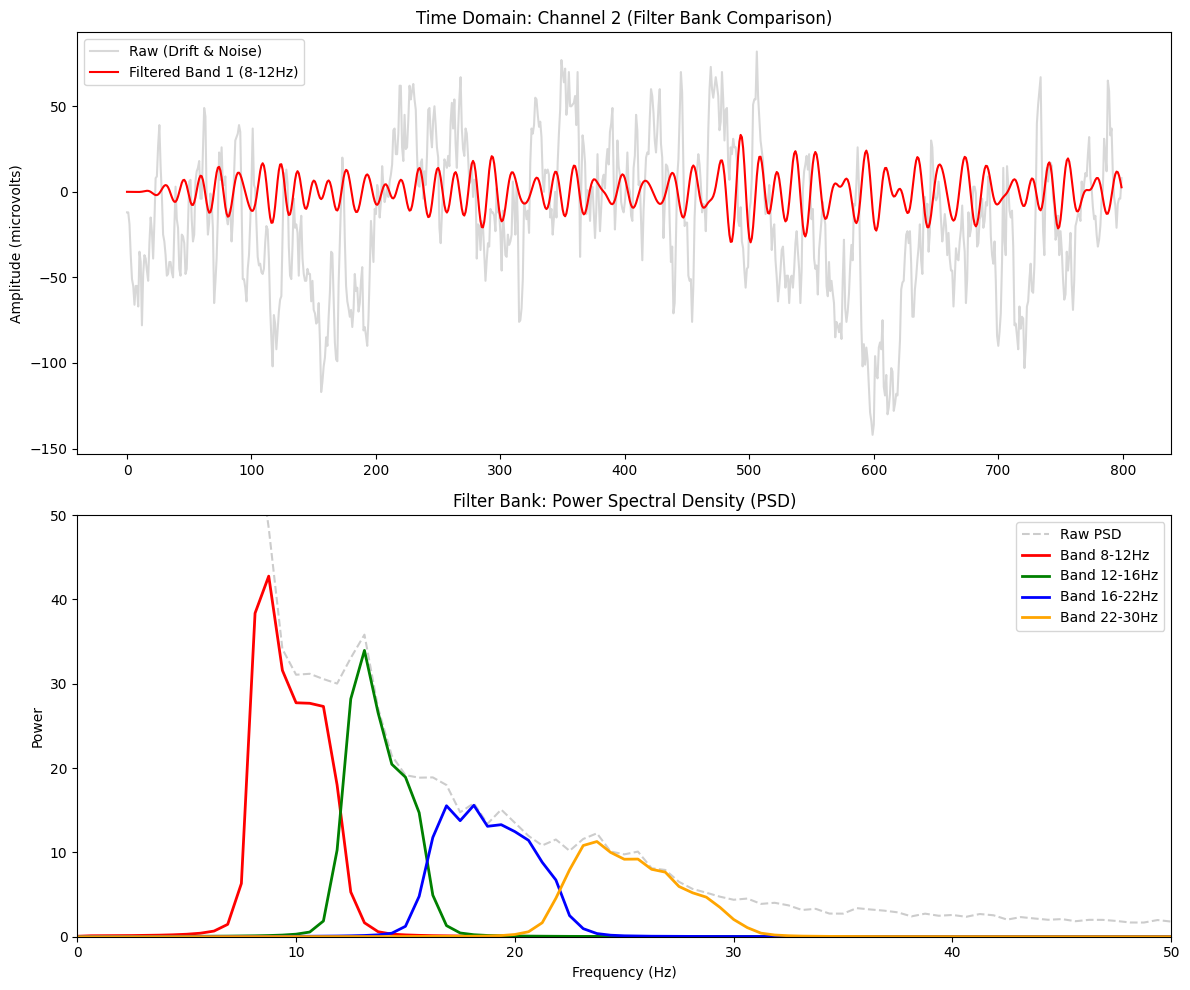

In [20]:
import matplotlib.pyplot as plt
# FOR TRAINING SET
# 1. Setup Parameters
ch = 2  # Plotting Channel 2 (usually a good motor channel)
sampling_rate = 160  # From your previous code
bands = [(8, 12), (12, 16), (16, 22), (22, 30)]
colors = ['red', 'green', 'blue', 'orange']

plt.figure(figsize=(12, 10))

# --- Subplot 1: Time Domain (First 5 Seconds) ---
plt.subplot(2, 1, 1)
plt.plot(x_train_raw[ch][:800], label='Raw (Drift & Noise)', alpha=0.3, color='gray')

# Plot just the first band (8-12Hz) as an example of the "Clean" wave
plt.plot(x_train_fb[0][ch][:800], label='Filtered Band 1 (8-12Hz)', color='red', linewidth=1.5)

plt.title(f'Time Domain: Channel {ch} (Filter Bank Comparison)')
plt.ylabel('Amplitude (microvolts)')
plt.legend()

# --- Subplot 2: Frequency Domain (The "Humps") ---
plt.subplot(2, 1, 2)

# Calculate and plot Raw PSD
psd_raw = DataFilter.get_psd_welch(x_train_raw[ch], 256, 128, sampling_rate, 0)
plt.plot(psd_raw[1], psd_raw[0], label='Raw PSD', color='black', alpha=0.2, linestyle='--')

# Loop through each band in the Filter Bank and plot its PSD
for i, (low, high) in enumerate(bands):
    # Calculate PSD for the i-th filtered version of this channel
    psd_band = DataFilter.get_psd_welch(x_train_fb[i][ch], 256, 128, sampling_rate, 0)
    plt.plot(psd_band[1], psd_band[0], label=f'Band {low}-{high}Hz', color=colors[i], linewidth=2)

plt.title('Filter Bank: Power Spectral Density (PSD)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.xlim(0, 50)  # Focus on the 0-50Hz range to see the bands clearly
plt.ylim(0, 50)  # Adjust based on your signal's power level
plt.legend()

plt.tight_layout()
plt.show()

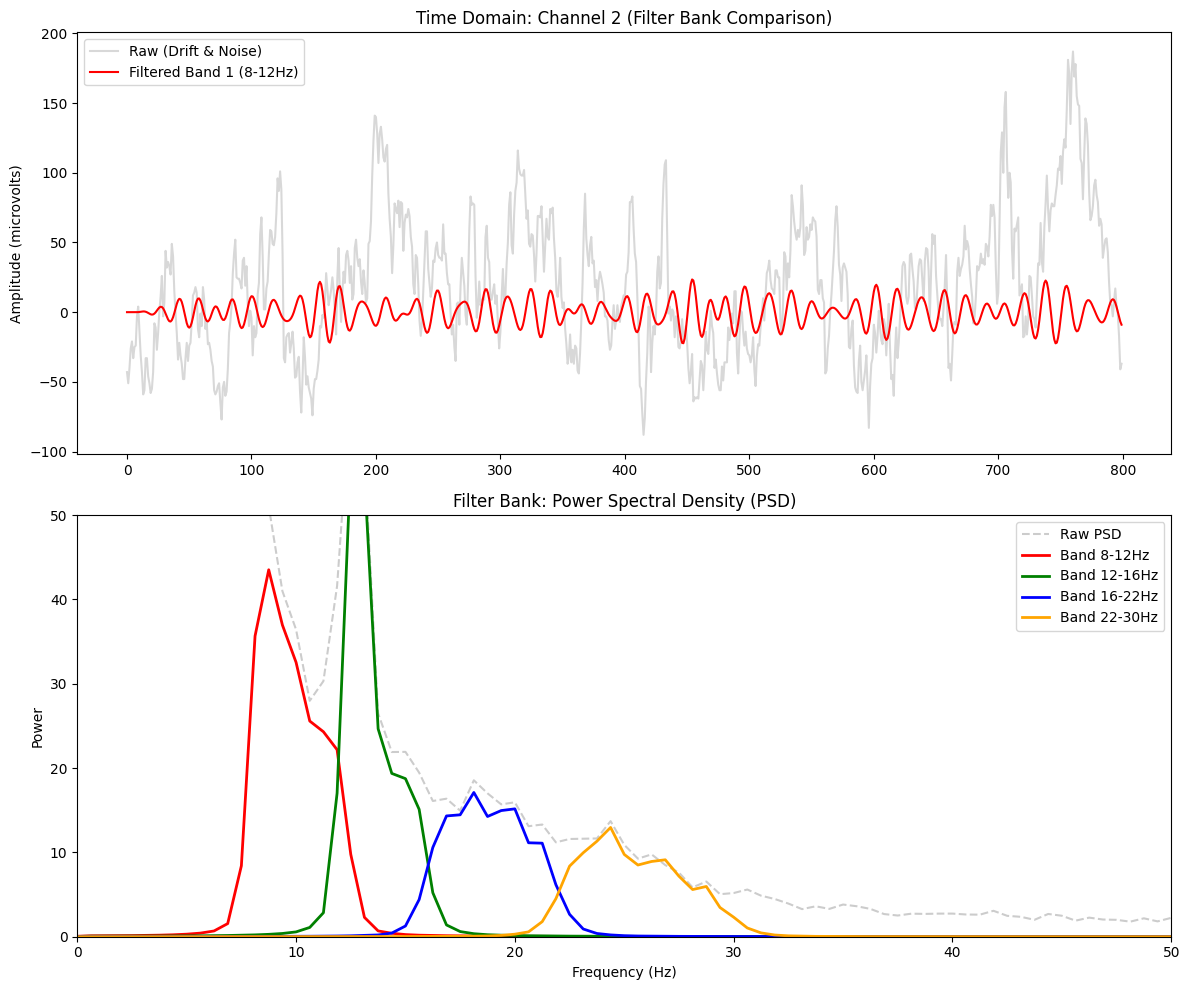

In [21]:
import matplotlib.pyplot as plt
# FOR TESTING SET
# 1. Setup Parameters
ch = 2  # Plotting Channel 2 (usually a good motor channel)
sampling_rate = 160  # From your previous code
bands = [(8, 12), (12, 16), (16, 22), (22, 30)]
colors = ['red', 'green', 'blue', 'orange']

plt.figure(figsize=(12, 10))

# --- Subplot 1: Time Domain (First 5 Seconds) ---
plt.subplot(2, 1, 1)
plt.plot(x_test_raw[ch][:800], label='Raw (Drift & Noise)', alpha=0.3, color='gray')

# Plot just the first band (8-12Hz) as an example of the "Clean" wave
plt.plot(x_test_fb[0][ch][:800], label='Filtered Band 1 (8-12Hz)', color='red', linewidth=1.5)

plt.title(f'Time Domain: Channel {ch} (Filter Bank Comparison)')
plt.ylabel('Amplitude (microvolts)')
plt.legend()

# --- Subplot 2: Frequency Domain (The "Humps") ---
plt.subplot(2, 1, 2)

# Calculate and plot Raw PSD
psd_raw = DataFilter.get_psd_welch(x_test_raw[ch], 256, 128, sampling_rate, 0)
plt.plot(psd_raw[1], psd_raw[0], label='Raw PSD', color='black', alpha=0.2, linestyle='--')

# Loop through each band in the Filter Bank and plot its PSD
for i, (low, high) in enumerate(bands):
    # Calculate PSD for the i-th filtered version of this channel
    psd_band = DataFilter.get_psd_welch(x_test_fb[i][ch], 256, 128, sampling_rate, 0)
    plt.plot(psd_band[1], psd_band[0], label=f'Band {low}-{high}Hz', color=colors[i], linewidth=2)

plt.title('Filter Bank: Power Spectral Density (PSD)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.xlim(0, 50)  # Focus on the 0-50Hz range to see the bands clearly
plt.ylim(0, 50)  # Adjust based on your signal's power level
plt.legend()

plt.tight_layout()
plt.show()

In [22]:
print("--- Data Dimensions ---")
print(f"Training features shape:   {x_train_filt.shape} (Channels, Samples)")
print(f"Training labels shape:   {y_train_clean.shape}  (Channels, Samples)")
print(f"Testing features shape:   {x_test_filt.shape} (Channels, Samples)")
print(f"Testing labels shape:   {y_test_clean.shape}  (Channels, Samples)")

--- Data Dimensions ---
Training features shape:   (84, 39840) (Channels, Samples)
Training labels shape:   (1, 39840)  (Channels, Samples)
Testing features shape:   (84, 19920) (Channels, Samples)
Testing labels shape:   (1, 19920)  (Channels, Samples)


# **PHASE 3: CSP FEATURE EXTRACTION AND OPTIMIZATION**

**1. Objective:** To transform segmented 3D EEG windows into a 2D feature matrix optimized for Motor Imagery classification. This phase reduces high-dimensional raw data into a set of frequency-based power features.



**2. Step-by-step Pipeline**


*   Step 1: Data Segmentation  
      * The continuous EEG data is going to be "chopped" into 540 overlapping windows of shape (64, 128).
      * **Goal**: Ensure that each window represent a single mental state (Rest, Left, or Right).



* Step 2: Regularized Filter Bank CSP (New Engine):
    * We have replaced the standard CSP with a Regularized Filter Bank CSP (FBCSP). This is the core of our optimization:

    * **Sub-Band Processing:** Instead of one wide frequency range, we now process 4 sub-bands simultaneously.

    * **Spatial Focus:** By using 21 channels and limiting the output to n=8 components, we force the model to ignore noise and focus strictly on the motor cortex.
    * **Regularization:** We implemented reg='ledoit_wolf'. This mathematically "smooths" the covariance matrices, which was the key step in solving our overfitting problem.

* **Step 3: Streamlining the Codebase**: Because this new CSP implementation is more robust and produces cleaner features, several previous processing stages are now redundant.


> Because this CSP engine uses Ledoit-Wolf regularization and internal log-variance calculation (log=True), we no longer need these lines of code:


1.   Old CSP code
2.   PSD
3.   Get Average BandPower
4.   Feature Matrix


* Step 4: Final Feature Mapping

The output of this phase is a stable feature vector that represents the log-variance of the brain's "Mu" and "Beta" rhythms. This cleaned data is then passed directly to the machine learning classifiers, resulting in a model where the Practice Score and Final Test Score are finally aligned.

## Data Segmentation
### 1. **Objective:**
* Transform EEG recording into discrete, labeled snapshots (windows) suitable for Machine Learning.
     * This segmentation must respect experimental trial boundaries to prevent "label contamination", where a window has recording belong to two different labels.

### 2. **Input Data Specifications**
* Source Data: 64-channel EEG array with a sampling rate of 160Hz
* Total Samples: 39,840
* Trial Stucture:
     * Action Trials: 656 samples (4.1s)
     * Rest Trials: 672 samples (4.2s)
* Trial Sequence: 30 cycles of alternating Action (Left, Right) and Rest trials.

### 3. **Windowing Parameters**
* Window Size: 128 samples (for better frequency resolution)
* Step Size: 64 samples (50% overlap)
* Constraint: Windows are strictly contained within their respective trials. Any samples remaining at the end of a trial that cannot form a full 128-sample window are discarded.

### 4. **Implementation Logic**:

The algorithm utilizes a nested loop structure to traverse the dataset:

1. **Outer Loop:** Iterates through trial_info, which defines the duration and label for each segment.
2. **Window Calculation:** For each trial, the number of valid windows is calculated using the formula:

      **(Duration - Window_Size) // Step_Size + 1**
3. **Inner Loop:** Extracts slices from the raw EEG array.
* **Start Index**: trial_start + (i * step_size)
* **End Index**: start + window_size (ensure same window length)

4. **Labeling:** Each extracted window is assigned the label associated with its parent trial.

### **5. Final Output Structure**

* **Feature Array (X)**: A 3D NumPy array of shape (540, 64, 128)

     * 540: Total number of extracted windows (Epochs)
     * 64: Number of EEG channels
     * 128: Samples (Length of the window)

* **Label Array (y)**: A 1D NumPy array of shape (540,) containing the corresponding class tags.

In [23]:
# Preparing stuff-ish.
label_list_1 = ["Right", "Rest", "Left", "Rest", "Left", "Rest", "Right", "Rest", "Right", "Rest", "Left", "Rest", "Left", "Rest", "Right", "Rest", "Left", "Rest", "Right", "Rest", "Right", "Rest", "Left", "Rest", "Left", "Rest", "Right", "Rest", "Left", "Rest"]
label_list_2 = ["Left", "Rest", "Right", "Rest", "Left", "Rest", "Right", "Rest", "Left", "Rest", "Right", "Rest", "Right", "Rest", "Left", "Rest", "Left", "Rest", "Right", "Rest", "Right", "Rest", "Left", "Rest", "Right", "Rest", "Left", "Rest", "Left", "Rest"]
label_list_3 = ["Left", "Rest", "Right", "Rest", "Right", "Rest", "Left", "Rest", "Right", "Rest", "Left", "Rest", "Left", "Rest", "Right", "Rest", "Right", "Rest", "Left", "Rest", "Left", "Rest", "Right", "Rest", "Right", "Rest", "Left", "Rest", "Right", "Rest"]
training_label = label_list_1 + label_list_2
testing_label = label_list_3

In [24]:

def prepare_trial(label):
  trial_info = [] # Will be in format (duration, label)
  for info in label:
    if info == "Left":
      trial_info.append((656, 1))
    elif info == "Right":
      trial_info.append((656, 2))
    elif info == "Rest":
      trial_info.append((672, 0))
  return trial_info
trial_info_training = prepare_trial(training_label)
trial_info_testing = prepare_trial(testing_label)

In [25]:
def split_window(trial_info, data, window_size=128, steps=64):
    curr_indx = 0
    all_windows = []
    all_labels = []

    for duration, label in trial_info:
        trial_start = curr_indx
        trial_end = trial_start + duration
        # Calculation for num_windows
        num_windows = (duration - window_size) // steps + 1

        for i in range(num_windows):
            start = trial_start + (i * steps)
            end = start + window_size
            window = data[:, start:end]

            all_windows.append(window)
            all_labels.append(label)

        curr_indx = trial_end

    # --- MOVE THESE OUTSIDE THE FOR LOOP ---
    X = np.array(all_windows)
    y = np.array(all_labels)
    return X, y
X_train, y_train = split_window(trial_info_training, x_train_filt)
X_test, y_test = split_window(trial_info_testing, x_test_filt)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(540, 84, 128)
(540,)
(270, 84, 128)
(270,)


In [26]:
values, counts = np.unique(y_train, return_counts=True)

for value, count in zip(values, counts):
    print(f"{value} occurs {count} times")

0 occurs 270 times
1 occurs 144 times
2 occurs 126 times


In [27]:
values, counts = np.unique(y_test, return_counts=True)

for value, count in zip(values, counts):
    print(f"{value} occurs {count} times")

0 occurs 135 times
1 occurs 63 times
2 occurs 72 times


## Feature Consolidation & Stratified Partitioning

After the data segmentation and windowing, we consolidate our fragmented data chunks into a signal master **Feature Matrix (X)** and **Label Vector (y)**.



*   **Reason for Merging**: We merge out segmented training and testing data to allow modern ML to handle shuffling an splitting automatically.
*   **Detailed Process**: By using a unified pool, we can perform a **stratified split** (typically 80% training and 20% testing). This ensures that each class (Rest, Left, Right) is represented equally in both sets, preventing the model from becoming biased toward one specific type of movement.



In [28]:
from sklearn.model_selection import train_test_split
X = np.vstack((X_train, X_test))
y = np.hstack((y_train, y_test))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # Stratify for shuffling
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(648, 84, 128)
(648,)
(162, 84, 128)
(162,)


## The Regularized CSP Engine
In this phase, we optimized how the spatial patterns are extracted from our 21-channel sub-bands. The primary goal was to move from "complex and fragile" to "simple and stable."

### The Core Configuration:

* Channels: 21 (Motor Plus) — eliminating non-motor noise at the source.

* n_components: 8 — providing a balanced "spatial summary" of each band.

* Regularization: reg='ledoit_wolf' — the critical "noise-filter" for our covariance matrices.

In [29]:
!pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 30.6 MB/s eta 0:00:00


In [30]:
from mne.decoding import CSP

# 1. Initialize CSP
# We use 6 components to find the best 6 features from the 256 channels'ledoit_wolf'
csp = CSP(n_components=8, reg='ledoit_wolf', log=True, norm_trace=False)

# 2. Fit and Transform the segmented data
# This turns (540, 256, 128) into (540, 6)
X_train_features = csp.fit_transform(X_train, y_train)
X_test_features = csp.transform(X_test)

# 3. Now pass these 6 features straight to your ML models
# (No manual PSD or Band Power required if 'log=True' in CSP)


Computing rank from data with rank=None
    Using tolerance 2.6e+02 (2.2e-16 eps * 84 dim * 1.4e+16  max singular value)
    Estimated rank (data): 84
    data: rank 84 computed from 84 data channels with 0 projectors
Reducing data rank from 84 -> 84
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Estimating class=2 covariance using LEDOIT_WOLF
Done.


In [31]:
print(X_train_features.shape)
print(y_train.shape)
print(X_test_features.shape)
print(y_test.shape)

(648, 8)
(648,)
(162, 8)
(162,)


# **PHASE 4: MACHINE LEARNING CLASSIFICATION**
 ### This phase is designed to benchmark multiple algorithms to find the most robust classifier for distinguishing between Left Hand, Right Hand, and Rest states.

1. **Model Selection & Configuration**

We utilize scikit-learn to implement three distinct classes of algorithms. This provides a mix of linear, non-linear, and ensemble approaches to handle the complexity of EEG data.

**i) Logistic Regression - Linear**
- Serves as a baseline. Good for high-dimensional data if the classes are linearly separable.
- Key parameters: class_weight='balanced', max_iter=1000

**ii) Random Forest - Ensemble**
- Robust against overfitting and handles non-linear relationships well.
- Key parameters: class_weight='balanced'

**iii) Support Vector Machine (SVM) - Kernel-based**
- The industry standard for BCI. Finds the optimal hyperplane to separate classes in high-dimensional space.
- Key parameters: class_weight='balanced', probability=True

**NOTE**: Because the "Rest" labels doubles the "Left" and "Right" labels, there's an imbalance in the training data, hence why all models use **class_weight='balanced'**


---
2. **Hyperparameter Tuning (GridSearch)**

To optimize performance, we wrap each model in a Pipeline with a StandardScaler (to normalize features) and use GridSearchCV to test different parameter combinations.

- **LogReg**: Tuned the Regularization strength (C: 0.01 to 100).
- **Random Forest**: Tuned the number of trees (n_estimators) and tree depth (max_depth) to control complexity.
- **SVM**: Tuned the Regularization (C) and the Kernel type (linear, rbf, sigmoid).

---
3. **Evaluation Metrics**

We rely on two primary outputs to see the model's success:

- **Accuracy Table**: Compares the "Practice" (CV) score vs. the "Final" (Test) score to check for overfitting. (e.g., RandomForest showed a large gap, indicating potential overfitting, while SVM was more stable).

- **Confusion Matrix**: Visualizes exactly where the model makes mistakes (e.g., confusing Left for Rest) rather than just giving a single percentage.

---
4. **Performance Summary & Comparison to Version 0

The models were evaluated using 5-Fold Cross-Validation (Practice Score) and a held-out Test Set (Final Exam Score).

**A. Current Best Configuration (21 Channels)**
- Using the 21 motor channels proved to have the best accuracy, likely because that amount was sufficient for CSP to grasp the best variance to classify the classes.

  - Top Performer: SVM (Support Vector Machine), RandomForest

  - Final Test Accuracy: ~66.0% (RandomForest), ~63.6% (SVM)

  - Best Params: kernel='linear', C=1 (SVM) / class_weights = 'balanced', max_depth=10, n_iterations = 200 (RandomForest)
  - RandomForest goes from ~60% -> ~66.0%, which is way overfitting, while SVM has little overfitting, which is why we have 2 top performer.

**B. Comparision to Version 0**:
- While Version 0 produced a singular high-accuracy peak with the SVM (66.6%), the model exhibited low practice scores (avg. 58%), suggesting instability.
- Version 1 (Optimized) increased the baseline practice performance to ~62% and delivered a highly stable 63.6% with SVM.
- This demonstrates that the 21-channel Filter Bank setup provides a more reliable and reproducible foundation for Motor Imagery classification.


In [32]:
# Import ML models, gridsearch, pipeline, scaler.
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [33]:
# Prepare lists of models to test and params.
models = {
    'LogReg': LogisticRegression(class_weight='balanced', max_iter=1000),
    'RandomForest': RandomForestClassifier(class_weight='balanced'),
    'SVM': SVC(class_weight='balanced', probability=True)
}

params = {
    'LogReg' : {'clf__C': [0.01, 0.1, 1, 10, 100]},
    'RandomForest' : {'clf__n_estimators' : [50, 100, 150, 200], 'clf__max_depth': [5,10, 15, 20]},
    'SVM': {'clf__C': [0.1, 1, 10, 100], 'clf__kernel': ['linear', 'rbf', 'sigmoid']}
}

In [34]:
best_models = {}

for name in models:
  print(f"Training {name}...")

  pipe = Pipeline([
      ('scaler', StandardScaler()),
      ('clf', models[name])
  ])

  grid = GridSearchCV(pipe, params[name], cv=5, scoring='balanced_accuracy')
  grid.fit(X_train_features, y_train)

  best_models[name] = {
        'best_score': grid.best_score_,
        'best_params': grid.best_params_,
        'final_model': grid.best_estimator_
  }

for name, results in best_models.items():
    print(f"{name}: Best Score = {results['best_score']:.4f} ; Best params = {results['best_params']}")
    print(f"{results['final_model']}")


Training LogReg...
Training RandomForest...
Training SVM...
LogReg: Best Score = 0.6201 ; Best params = {'clf__C': 10}
Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 LogisticRegression(C=10, class_weight='balanced',
                                    max_iter=1000))])
RandomForest: Best Score = 0.6044 ; Best params = {'clf__max_depth': 10, 'clf__n_estimators': 200}
Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        n_estimators=200))])
SVM: Best Score = 0.6378 ; Best params = {'clf__C': 1, 'clf__kernel': 'rbf'}
Pipeline(steps=[('scaler', StandardScaler()),
                ('clf', SVC(C=1, class_weight='balanced', probability=True))])


In [35]:
results_summary = []

for name, info in best_models.items():
    # 1. Grab the winning pipeline for this model type
    model_pipeline = info['final_model']

    # 2. Run the "Final Exam" on the test data
    test_score = model_pipeline.score(X_test_features, y_test)

    # 3. Store the comparison
    results_summary.append({
        'Model': name,
        'Practice Score (CV)': info['best_score'],
        'Final Exam Score (Test)': test_score
    })

# 4. Display as a table (or just print)
import pandas as pd
print(pd.DataFrame(results_summary))

          Model  Practice Score (CV)  Final Exam Score (Test)
0        LogReg             0.620072                 0.604938
1  RandomForest             0.604367                 0.660494
2           SVM             0.637818                 0.635802


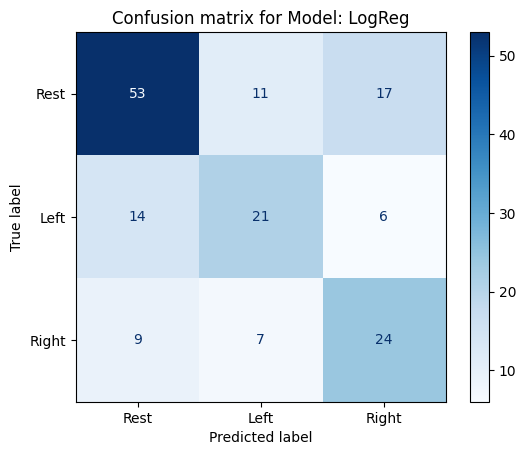

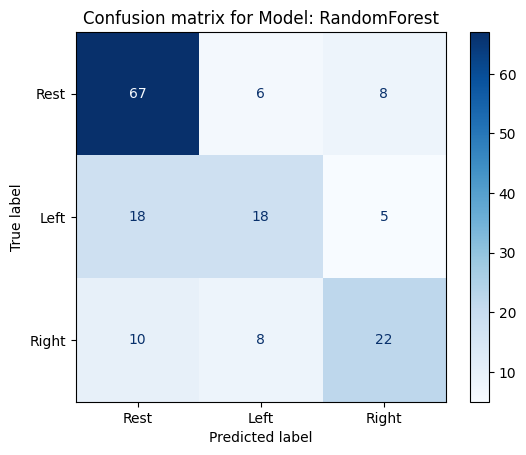

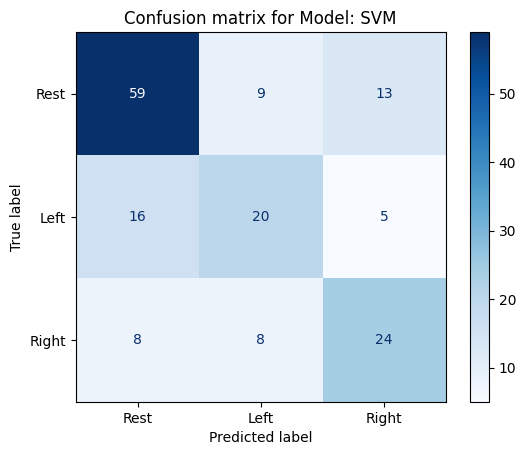

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def plot_confusion_matrix(grid_result, X_test_features, y_test, name):
  best_pipeline = grid_result['final_model']

  cmd = ConfusionMatrixDisplay.from_estimator(
        best_pipeline,
        X_test_features,
        y_test,
        display_labels=['Rest', 'Left', 'Right'],
        cmap=plt.cm.Blues
    )

  plt.title(f"Confusion matrix for Model: {name}")
  plt.show()

for name, results in best_models.items():
  plot_confusion_matrix(results, X_test_features, y_test, name)